# Trading Strategy Backtester
Used historical equity price data for Apple (AAPL), Microsoft(MSFT), and Google (GOOGL)

## 1. Installing Data

In [15]:
!pip -q install yfinance

## 2. Importing Libraries

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 3. Adding Multiple Stocks



In [17]:
tickers = ["AAPL", "MSFT", "GOOGL"]

START = "2020-01-01"
END   = "2025-01-01"

FAST = 20
SLOW = 50
RSI_PERIOD = 14
RSI_CAP = 70
COST = 0.001  #0.1% per buy/sell

## 4. Downloading Stock Data

In [23]:
data = {}

for t in tickers:
    df = yf.download(t, start=START, end=END, auto_adjust=True)

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns.name = None
    df = df.dropna()

    data[t] = df

for t in tickers:
    print(f"\n================ {t} =================")
    display(data[t].head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


================ AAPL =================


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.468254,72.528574,71.223252,71.476592,135480400
2020-01-03,71.763725,72.523754,71.539337,71.696167,146322800
2020-01-06,72.335533,72.374139,70.634517,70.885450,118387200
2020-01-07,71.995361,72.600968,71.775796,72.345212,108872000
2020-01-08,73.153488,73.455087,71.698574,71.698574,132079200



================ MSFT =================


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,152.505707,152.610150,150.331401,150.758664,22622100
2020-01-03,150.606735,151.869547,150.075028,150.321902,21116200
2020-01-06,150.996048,151.062519,148.603350,149.144562,20813700
2020-01-07,149.619263,151.603675,149.372403,151.271365,21634100
2020-01-08,152.002457,152.676595,149.970567,150.901055,27746500



================ GOOGL =================


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,67.920815,67.920815,66.819638,66.914918,27278000
2020-01-03,67.565491,68.172409,66.860816,66.894565,23408000
2020-01-06,69.366379,69.391685,67.043431,67.074689,46768000
2020-01-07,69.232399,69.648755,69.056232,69.497895,34330000
2020-01-08,69.725174,70.063120,69.109328,69.218004,35314000


## 5. Plotting the Price

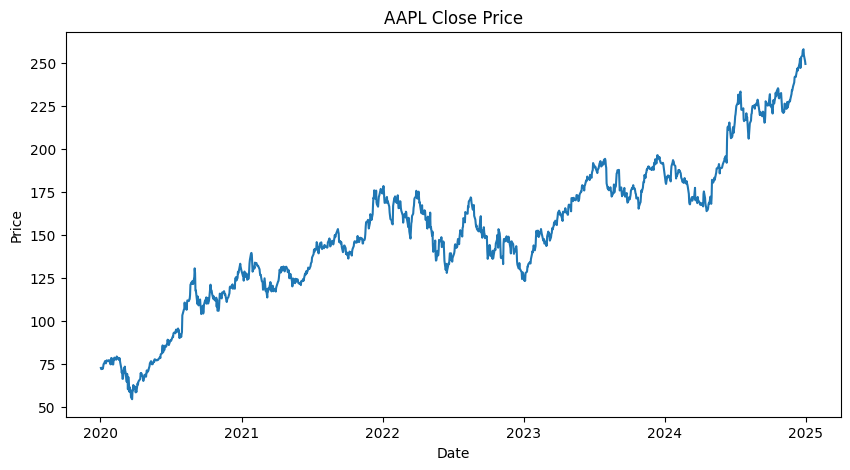

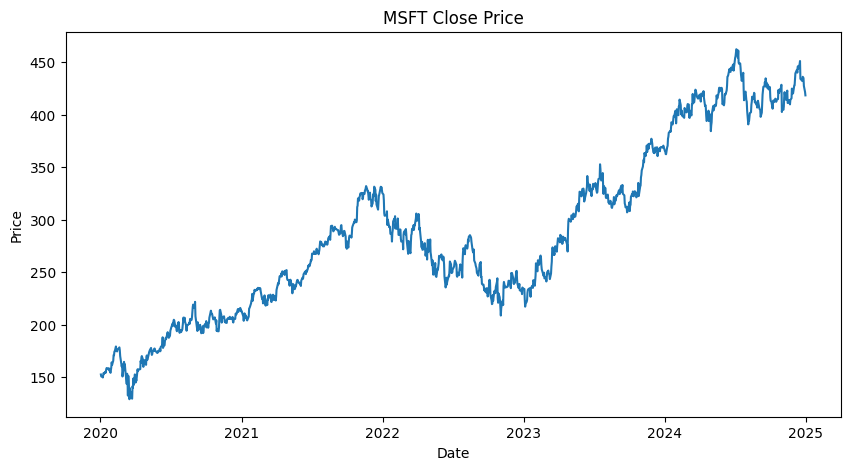

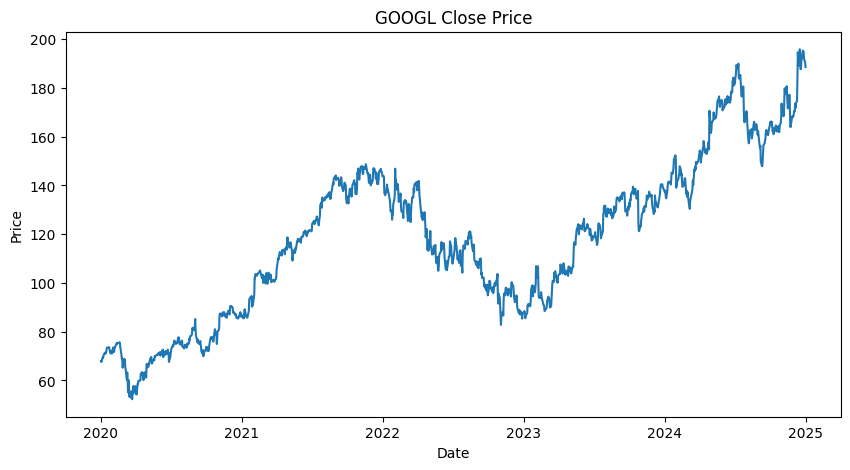

In [24]:
for t in tickers:
    df = data[t]
    plt.figure(figsize=(10,5))
    plt.plot(df["Close"])
    plt.title(f"{t} Close Price")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

## 6. Adding Fast and Slow Moving Averages

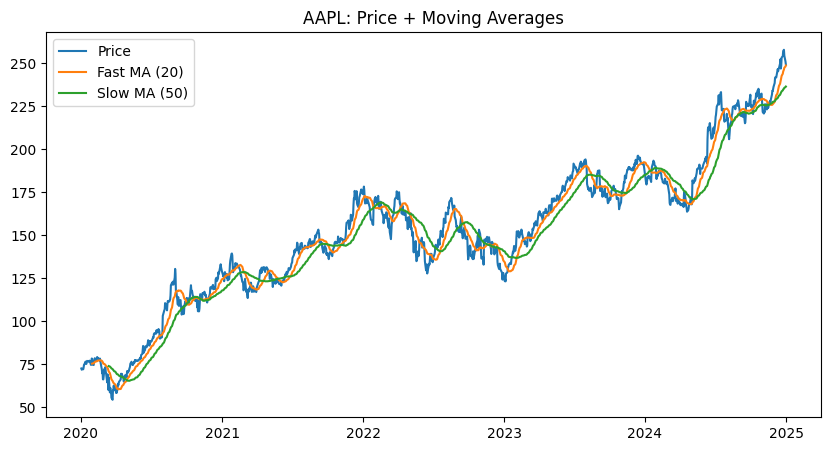

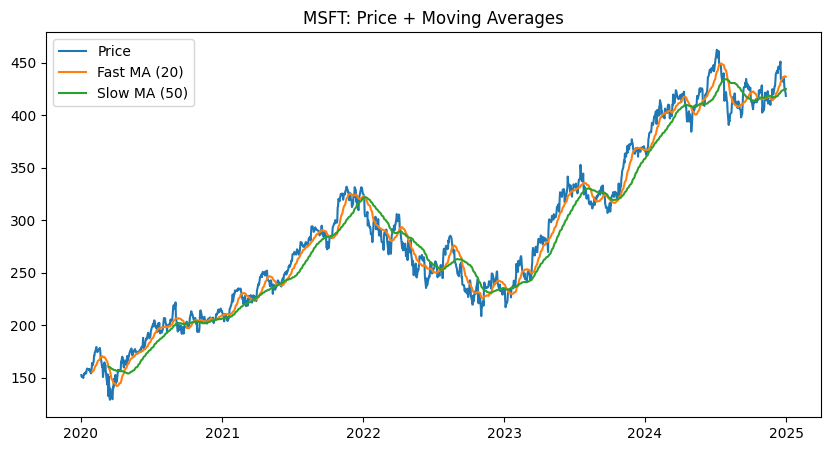

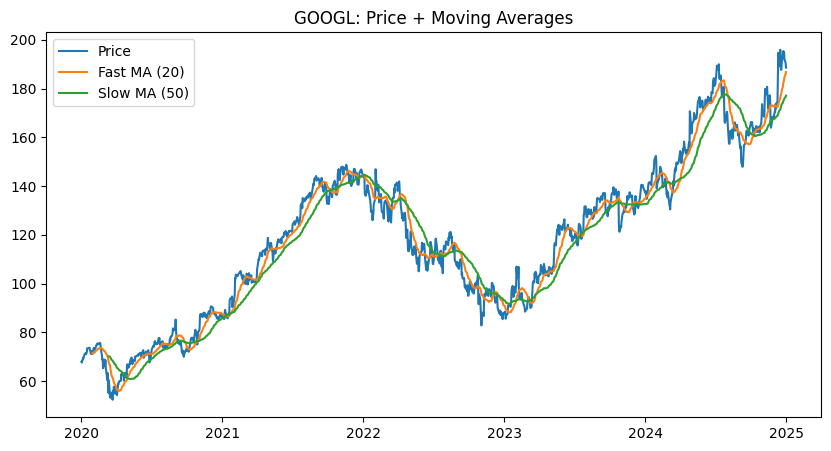

In [25]:
for t in tickers:
    df = data[t]
    df["fast_ma"] = df["Close"].rolling(FAST).mean()
    df["slow_ma"] = df["Close"].rolling(SLOW).mean()

    plt.figure(figsize=(10,5))
    plt.plot(df["Close"], label="Price")
    plt.plot(df["fast_ma"], label=f"Fast MA ({FAST})")
    plt.plot(df["slow_ma"], label=f"Slow MA ({SLOW})")
    plt.title(f"{t}: Price + Moving Averages")
    plt.legend()
    plt.show()

## 7. Adding the Relative Strength Index (RSI)

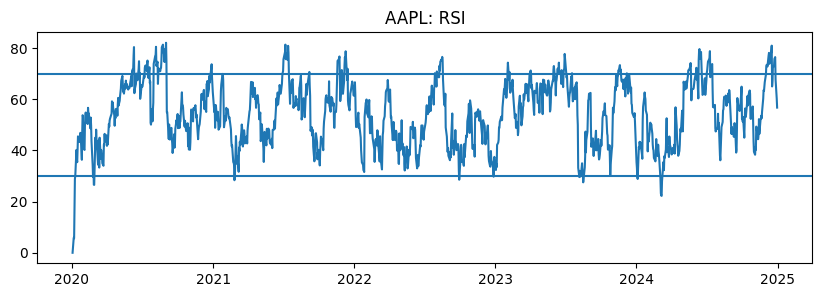

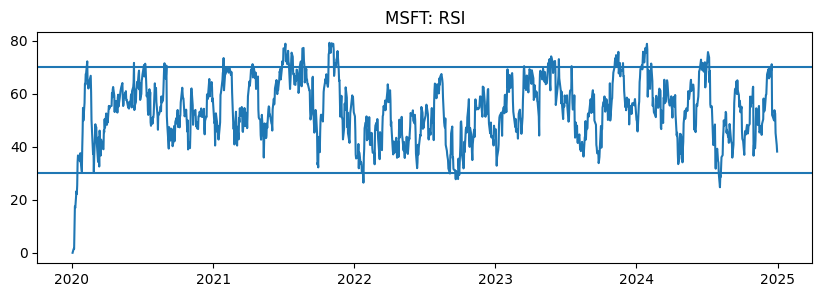

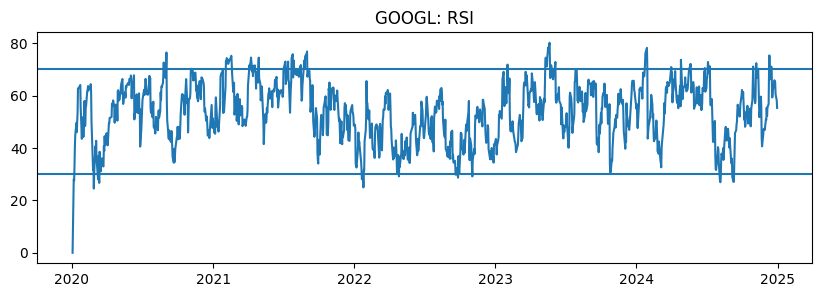

In [26]:
def rsi(close, period=14):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

for t in tickers:
    df = data[t]
    df["rsi"] = rsi(df["Close"], RSI_PERIOD)

    plt.figure(figsize=(10,3))
    plt.plot(df["rsi"])
    plt.axhline(70)
    plt.axhline(30)
    plt.title(f"{t}: RSI")
    plt.show()

## 8. Deciding the Signal

In [28]:
for t in tickers:
    print(f"\n===== {t} SIGNALS =====")
    display(data[t][["fast_ma", "slow_ma", "rsi", "signal"]].tail())


===== AAPL SIGNALS =====


,fast_ma,slow_ma,rsi,signal
Date,,,,
2024-12-24,245.184587,234.761245,75.750254,0
2024-12-26,246.377192,235.267494,76.452855,0
2024-12-27,247.405540,235.746621,67.626244,1
2024-12-30,248.145692,236.150895,60.225577,1
2024-12-31,248.684755,236.463049,56.715927,1



===== MSFT SIGNALS =====


,fast_ma,slow_ma,rsi,signal
Date,,,,
2024-12-24,436.135217,424.063442,53.750974,1
2024-12-26,436.637512,424.464613,52.452939,1
2024-12-27,437.011751,424.767206,45.156219,1
2024-12-30,437.079749,424.944745,40.584269,1
2024-12-31,436.609219,425.027640,38.153873,1



===== GOOGL SIGNALS =====


,fast_ma,slow_ma,rsi,signal
Date,,,,
2024-12-24,182.243233,174.843930,65.881609,1
2024-12-26,183.571711,175.448152,65.065342,1
2024-12-27,184.753270,176.001764,60.565057,1
2024-12-30,185.873055,176.569472,58.243218,1
2024-12-31,186.769859,177.088780,55.327768,1


## 9. Positioning (Avoiding current day's prices)

In [31]:
for t in tickers:
    df = data[t]
    df["position"] = df["signal"].shift(1).fillna(0)

for t in tickers:
    df = data[t]
    df["ret"] = df["Close"].pct_change().fillna(0)
    df["strategy_ret_gross"] = df["position"] * df["ret"]

## 10. Computing Returns

In [32]:
df["ret"] = df["Close"].pct_change().fillna(0)
df["strategy_ret"] = df["position"] * df["ret"]

## 11. Equity Curve (Buy & Hold vs Strategy)

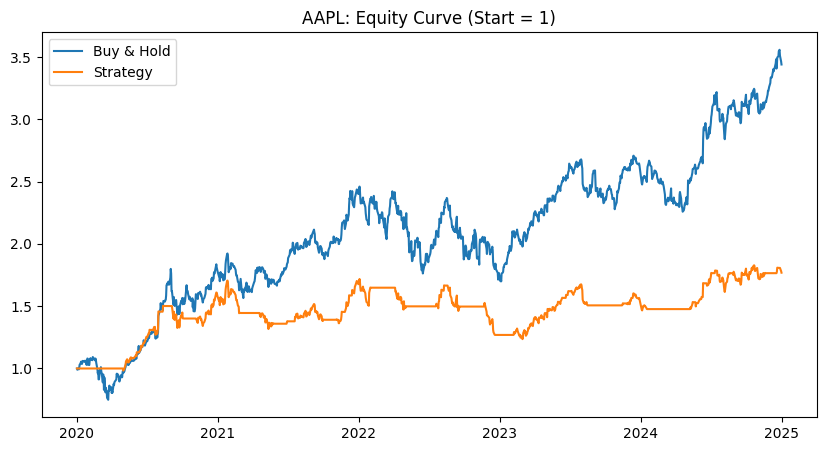

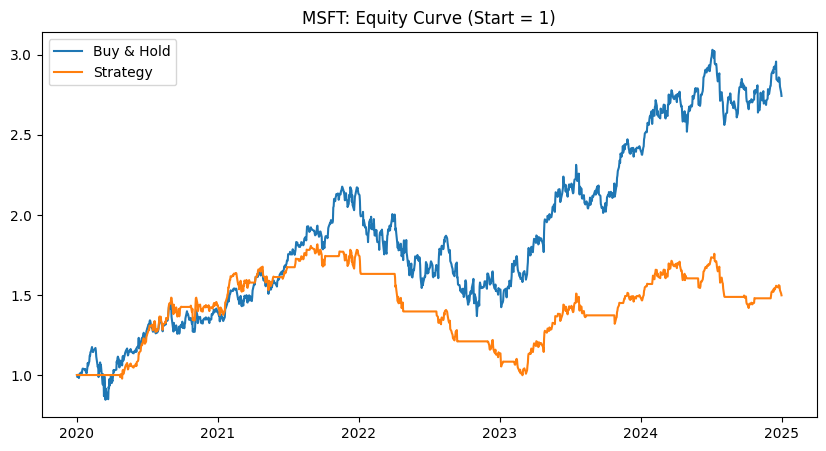

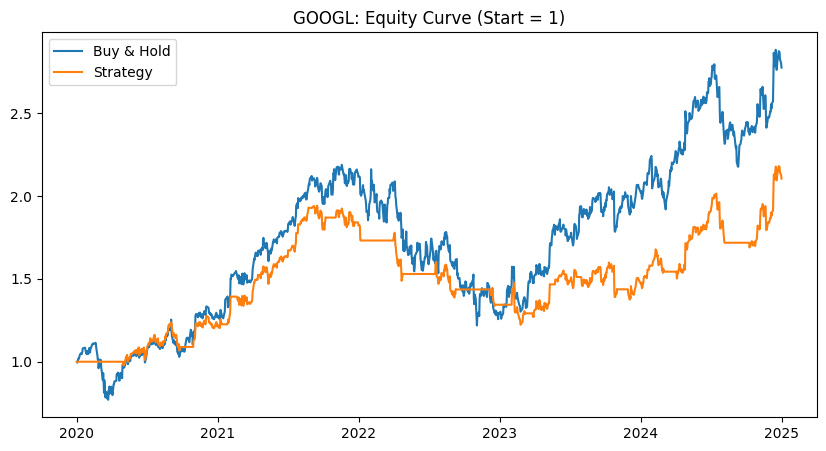

In [35]:
for t in tickers:
    df = data[t]
    df["ret"] = df["Close"].pct_change().fillna(0)
    df["strategy_ret_gross"] = df["position"] * df["ret"]

for t in tickers:
    df = data[t]
    df["trade"] = df["position"].diff().abs().fillna(0)
    df["strategy_ret"] = df["strategy_ret_gross"] - df["trade"] * COST

for t in tickers:
    df = data[t]
    df["equity_buyhold"] = (1 + df["ret"]).cumprod()
    df["equity_strategy"] = (1 + df["strategy_ret"]).cumprod()

    plt.figure(figsize=(10,5))
    plt.plot(df["equity_buyhold"], label="Buy & Hold")
    plt.plot(df["equity_strategy"], label="Strategy")
    plt.title(f"{t}: Equity Curve (Start = 1)")
    plt.legend()
    plt.show()


## 12. Adding metrics

In [36]:
def max_drawdown(equity):
    peak = equity.cummax()
    dd = equity/peak - 1
    return dd.min()

def sharpe(daily_returns):
    if daily_returns.std() == 0:
        return np.nan
    return np.sqrt(252) * daily_returns.mean() / daily_returns.std()

rows = []

for t in tickers:
    df = data[t]
    years = len(df) / 252
    cagr = df["equity_strategy"].iloc[-1]**(1/years) - 1

    rows.append({
        "Ticker": t,
        "Final equity": float(df["equity_strategy"].iloc[-1]),
        "CAGR": float(cagr),
        "Sharpe": float(sharpe(df["strategy_ret"])),
        "Max Drawdown": float(max_drawdown(df["equity_strategy"])),
        "Trades": int(df["trade"].sum())
    })

metrics_df = pd.DataFrame(rows)[["Ticker","Final equity","CAGR","Sharpe","Max Drawdown","Trades"]]
metrics_df

,Ticker,Final equity,CAGR,Sharpe,Max Drawdown,Trades
0,AAPL,1.768905,0.121036,0.708194,-0.280949,95
1,MSFT,1.497957,0.084316,0.529796,-0.450182,93
2,GOOGL,2.105929,0.160891,0.806607,-0.370370,97
